# Homework 7: Text classification with Keras

The homework consists of only coding part (25 pts).
 - All theoretical questions must be answered in your own words, do not copy-paste text from the internet. Points can be deducted for terrible formatting or incomprehensible English.
 - Code must be commented. If you use code you found online, you have to add the link to the source you used. There is no penalty for using outside sources as long as you convince us you understand the code.

**Note that coding part consists of two different notebooks.**

*Once completed zip the entire directory containing this exercise and upload it to https://courses.cs.ut.ee/2020/nn/spring/Main/Practices.*

**If you did this homework together with course mates, please write here their names (answers still have to be your own!).**

**Name(s):** Vladyslav Umerenko

## Introduction

In this practice session we are looking into text classification. This means we are going to touch topics like word embeddings and recurrent neural networks.

In [1]:
%matplotlib inline

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
import numpy as np
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Loading data

We are going to use IMDB moview review dataset for sentiment classification. Luckily, this is included with Keras again. 

In [2]:
(X_train_seq, y_train), (X_test_seq, y_test) = imdb.load_data()

print('Train data shape: ', X_train_seq.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test_seq.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (25000,)
Train labels shape:  (25000,)
Test data shape:  (25000,)
Test labels shape:  (25000,)


Inputs are the movie reviews encoded as sequences of word indexes. There are couple of "word indexes" with special meaning: 1 means start of sentence, 2 means unknown word (word not in vocabulary) and 0 means padding (empty) and should be ignored. Index 3 just does not exist (imdb.load_data() weird speciality).

All other numbers signify actualy words, with the smaller numbers coding for more frequently used words. Therefore 4 corresponds to the most used word in our database, 5 the second most used etc.

You can see below one encoded review. As expected it starts with 1, also expectedly 4 and 5 look quite frequent words indeed.

In [3]:
print(X_train_seq[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Our model should learn to produce the sentiment of the review: 1 movie is good, 0 movie is bad.

In [4]:
y_train[0]

1

As a data scientist you should always be a little bit more curious what the data is really about. In this case we might want to know what the text actually looked like. To decode the sequences of numbers into words, we need the number-to-word correspondences. Luckly Keras IMDB dataset has function for that.

In [5]:
word2num = imdb.get_word_index()
word2num

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

But this gives us only word-to-number encoding. We need to produce the inverse mapping (number-to-word) by ourselves.

**Task 1 (2pts):**

In [6]:
################################################################################
# TODO: Construct a dictionary for the opposite mapping, from numbers to words.#
################################################################################
num2word = {} # fill this dict with the inverse mapping
num2word = {num: word for word, num in word2num.items()}
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################
num2word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

Print out the most frequent words. Notice that this vocabulary indexing still starts from 1 (and not 4). Later when translating text into numbers or the other way round we will have to shift it by 3.

In [7]:
for i in range(1,11):
    print(str(i) + ':', num2word[i])

1: the
2: and
3: a
4: of
5: to
6: is
7: br
8: in
9: it
10: i


Now we can finally see what those movie reviews were about.

In [8]:
# function to decode reviews
def nums2sentence(nums):
    # the encoding has 0,1 and 2 as special numbers, 3 is omitted, therefore words start from nr 4
    # word indexes start from 1, so to match the two sysems we have to shift by 3 
    return " ".join(["UNK" if i == 2 else num2word[i-3] for i in nums[1:]]) 

# print the first 3 reviews
for i in range(3):
    print(nums2sentence(X_train_seq[i]), "- GOOD" if y_train[i] == 1 else "- BAD")
    print()

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

## Training model

Our goal in this exercise is to train a model to predict sentiment from the movie review text. Our neural networks expect fixed size inputs though, therefore we need to do some preprocessing first. In particular:
 - we need to make all sentences of the same length, so that the result can be represented as a matrix (tensor),
 - we might want to limit the vocabulary size to only certain number of more frequent words to save resources

In the following you will write a function to do those preprocessing steps.

**Task 2 (5pts):**

In [9]:
def preprocess_sequences(seq, vocab_size, maxlen):
    out = []
    ##############################################################################
    # TODO: Write a function to preprocess sequences:                            #
    #       - all sequences should have the same length - pad them with 0s at    #
    #         the beginning (the extra zeros go in the beginning of the list)    #
    #       - if sequence is too long (above maxlen), then keep only the maxlen  #
    #         words in end of the review(works better than keeping the beginning)#
    #       - remove all words with index >= vocab_size, replace them with 2s.   #
    #         (Words are ordered by frequency, so you are in fact removing less  #
    #         frequent words.)                                                   #
    ##############################################################################
    out = pad_sequences(seq, maxlen=maxlen)
    np.place(out, out[:, :] >= vocab_size, [2])
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return np.array(out)

vocab_size = 20000
maxlen = 80

X_train = preprocess_sequences(X_train_seq, vocab_size, maxlen)
assert X_train.shape[1] == maxlen, "Second dimension of training set must be equal to maximum sentence length."
assert np.max(X_train) < vocab_size, "The training set should not contain words with index >= vocab_size"
X_test = preprocess_sequences(X_test_seq, vocab_size, maxlen)

Now we are ready to create a network. Unconventionally our input layer processes only integers this time, corresponding to the words. These are fed to Embedding layer where the are transformed into the word vectors (embeddings) that are fed to subsequent layers. Using `mask_zero=True` tells the network that 0 is a special value that denotes padding. Timesteps where input is 0 will not be considered when backpropagating the error signal (no learning happens at those timesteps). 

Output of Embedding layer goes to RNN layer that walks over its inputs while keeping the hidden state as memory. Normally RNN layers produce output at each timestep, but here we have directed it with `return_sequences=False` to produce the output only at the last timestep.

As we have a binary classification task, we are using sigmoid as final activation and binary crossentropy as a loss function this time. If $y$ is the target value (1 or 0) and $p$ is the predicted probability (0..1) then the loss function looks like this:

$$
L = y \log p + (1 - y) \log (1 - p)
$$

This is basically equivalent to usual softmax categorical loss, where $y$ is the one-hot vector of target values and $p$ is the vector of probabilities that sums up to 1.

$$
L = \sum_i y_i \log p_i
$$


For more information see Keras documentation:

* [Embedding layers](https://keras.io/layers/embeddings/)
* [Recurrent layers](https://keras.io/layers/recurrent/)
* [Loss functions](https://keras.io/losses/)

In [10]:
#Definign a simple RNN 
embed_size = 128
rnn_size = 128

x = Input(shape=(None,), dtype='int32')
e = Embedding(vocab_size, embed_size, mask_zero=True)(x)
r = SimpleRNN(rnn_size, return_sequences=False)(e)
p = Dense(1, activation='sigmoid')(r)

rnn_model = Model(x, p)
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


**Task 3 (2pts):** What are the three dimensions of embedding layer output? Why LSTM layer is missing one of them?

**Your Answer:** First dimension is batch size, second is input sequence length and third is embedding dimension. LSTM is missing input sequence length, because if sequences aren't returned the output looses sequence dimension and has only the stated output dimension as well as batch size dimension.

Let's train the model for 1 epoch.

In [11]:
# Training the simple RNN, should get accuracy above 50% (maybe even 60%)
# you can change nr of epochs to train longer, if you can afford spending more time
history = rnn_model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_test, y_test))

/Users/post_protein/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 156s 6ms/step - loss: 0.6336 - accuracy: 0.6185 - val_loss: 0.6224 - val_accuracy: 0.6384


Simple RNN layer has limitations on how long it can keep its memory. The ability to remember can be imporved with gated recurrent layers like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit). Let's try to compare them! 

But for the comparison to be fair, the networks need to have approximately the same number of parameters. LSTM and GRU use additional gates that have additional weights. Your task is to create LSTM and GRU networks that have approximately the same number of parameters as the SimpleRNN network above and train them.

**Task 4 (1.5pts):**

In [14]:
##############################################################################
# TODO: 1) Construct a network with LSTM layer that has approximately the    #
#       same number of parameters as previous SimpleRNN network.             #                  
#       2) compile the model and print out summary                           #
#       3) train the model for one epoch (should get accuracy >80%)          #
##############################################################################
embed_size = 128
units = 64

x = Input(shape=(None,), dtype='int32')
e = Embedding(vocab_size, embed_size, mask_zero=True)(x)
r = LSTM(units, return_sequences=False)(e)
p = Dense(1, activation='sigmoid')(r)

lstm_model = Model(x, p)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = lstm_model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_test, y_test))

/Users/post_protein/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 249s 10ms/step - loss: 0.4216 - accuracy: 0.8021 - val_loss: 0.3688 - val_accuracy: 0.8390


**Task 5 (1.5pts):**

In [16]:
##############################################################################
# TODO: 1) Construct a network with GRU layer that has approximately the     #
#       same number of parameters as previous SimpleRNN network.             #                  
#       2) compile the model and print out summary                           #
#       3) train the model for one epoch (should get accuracy >80%)          #
##############################################################################
embed_size = 128
units = 64

x = Input(shape=(None,), dtype='int32')
e = Embedding(vocab_size, embed_size, mask_zero=True)(x)
r = GRU(units, return_sequences=False)(e)
p = Dense(1, activation='sigmoid')(r)

gru_model = Model(x, p)
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,597,121
Trainable params: 2,597,121
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = gru_model.fit(X_train, y_train, batch_size=32, epochs=1, validation_data=(X_test, y_test))

/Users/post_protein/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 239s 10ms/step - loss: 0.4253 - accuracy: 0.8000 - val_loss: 0.3880 - val_accuracy: 0.8314


**Task 6 (1.5pt):** Which recurrent unit produced the best results? How much smaller the LSTM or GRU layer had to be to be comparable to SimpleRNN in number of parameters?

**Your Answer:** The LSTM model performed better than GRU and RNN one, but the difference between LSTM and GRU models performance is almost insignificant. LSTM and GRU models require 2 times less hidden units compared to vanilla RNN models in order to preserve the amount of parameters.

In [18]:
##############################################################################
# TODO: Assign the best model to model variable.                             #
##############################################################################
model = gru_model
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Try it out

Let's try out the best model you have! Your job is to create your own movie reviews and make the model classify them as either good or bad.

**Task 7 (3pts):**

In [23]:
def words2sequences(words):
    return [word2num[w]+3 if w in word2num else 2 for w in text_to_word_sequence(words)]
def sentences2sequences(sentences):
    return [[1] + words2sequences(s) for s in sentences]

##############################################################################
# TODO: Write one positive (> 0.9) and one negative (< 0.1) movie review.    #
#       Try to write it yourself, do not just copy paste reviews from        #
#       somewhere until you find one that works.                             #
##############################################################################
myreviews = [
    "No comments. This masterpiece doesn't need any comments or reviews " +
    "to be left. One should just watch it and enjoy the gorgeous space " +
    "landscapes supplemented with brilliant soundtrack accompanied with " +
    "excellent actor work", # fill this with good review
    
    "Unfortunately, the movie appeared to be a huge disappointment and a total " +
    "waste of time. The narrative style was so boring that I was actually " +
    "thinking of leaving the cinema hall before the first half of the film."# fill this with bad review
]
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

myreviews_seq = sentences2sequences(myreviews)
X_myreviews = preprocess_sequences(myreviews_seq, vocab_size, maxlen)
model.predict(X_myreviews)


array([[0.94060045],
       [0.08772259]], dtype=float32)

**Task 8 (1pt):** How would you grade your handmade artificial intelligence?

**Your Answer:** Brilliant, but the input should be something more than a simple sentence for a confident prediction.

## Word embeddings

As mentioned above the network receives inputs as one-hot vectors. Multiplying this one-hot vector with the first weight layer transforms the words into some kind of real-valued vectors, we say it preforms embedding. Notice that as there is only one 1 in the one-hot input vector, effectlively each word corresponds to one row in the weight matrix.

We can think of the weights that correspond to each word as the representation of that word was given by the network. This representation depends on the task the network is performing, the dataset we use etc. The netowrk uses the representation that is most useful for it.

In this section we want to see if there is some consistency or logic in the representations that the network gives to the words. Are some word more similarly represented than others? To do so we first need to compress the 128-dimensional representation (the nr of nodes in Embedding layer) into 2D, in odrer to plot it. We can achieve this by using Principal Component Analysis (read more about it if you don't know what it is).

In [24]:
# let's extract the weight layer and make sure it's size makes sense
embed = model.layers[1].get_weights()[0]
embed.shape

(20000, 128)

Let's perform Principal Component Analysis on the rows of this matrix. We want to extract only the two most important axis of variance, because we want to plot the points in that space.


In [34]:
from sklearn.decomposition import PCA
embed_2d = PCA(n_components = 2).fit_transform(embed)
embed_2d.shape

(20000, 2)

Now we can look at where different words are positioned in the space defined by the first two components of PCA.

We define three sets of words that we color differently.

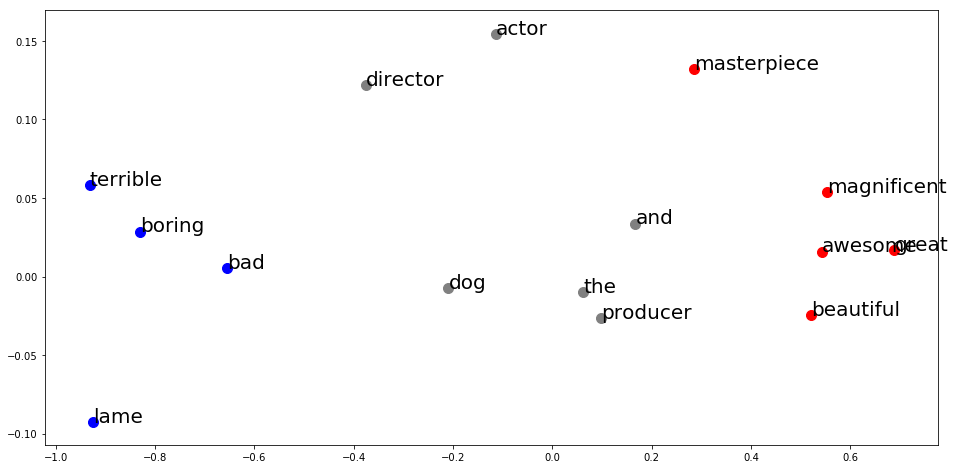

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
word_idx=[]
for word in ["great","awesome","beautiful","magnificent","masterpiece"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="red",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)
for word in ["bad", "terrible", "boring", "lame"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="blue",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

for word in ["actor", "producer", "director", "dog","and","the"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="gray",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

plt.show()


**Task 9 (1pt):** What meaning does the fist dimension of the PCA (the x-axis) seem to represent?

**Your Answer:** The x-axis seem to represent sentimental assessment, separating unpleasant feelings on the far left and delight on the far right, showing neutral relations in the middle of the axis.